 **Лабораторная работа. Копысов Марк**
В данной лабораторной работе анализируется датасет, описывающий клиентов банка, содержащий в совокупности разнородные числовые и категориальные признаки. Задачей анализа является построение модели классификации, с помощью которой можно будет одних людей отнести к тем, кто откроет срочный депозит (вклад), а других к тем, кто не станет его открывать.
Для начала, взглянем на обобщенные данные и попробуем сделать какие-либо выводы.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn
import csv
import sklearn

In [25]:
dataframe = pd.read_csv("bank-full.csv", sep = ';')
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Рассмотрим имеющиеся признаки и проведем первичный анализ. Датасет состоит приблизительно из данных по ~45k людям, известна их работа, женаты/замужем ли, образование, баланс (доллары на счету), имеется ли ипотека, имеются ли долги или другие кредиты, каким способом связывались с клиентом, когда в последний раз с ним связывались, и т.д.
Взглянем на среднее, медиану, среднеквадратическое отклонение.

__прим.__ Пропущенных значений в датасете нет.

In [26]:
dataframe.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Для более точных выводов необходимо рассмотреть распределения. Видно, что возраст распределен более-менее нормально. Люди среднего возраста (около 30) больше всего заинтересованы в открытии счёта. Интересно то, что желающие открыть накопительный счёт не обладают какими-либо значительными денежными суммами (см. __balance__, у квартиля 75% меньше 1500$ на счету). Большинство выборки занимают клиенты среднего возраста -- от 33 до 48 лет. Есть клиенты с огромными долгами, в среднем, деньги есть у всех (даже если это незначительные накопления), разброс довольно значителен. Каждый звонок клиенту длится около 4-х минут.

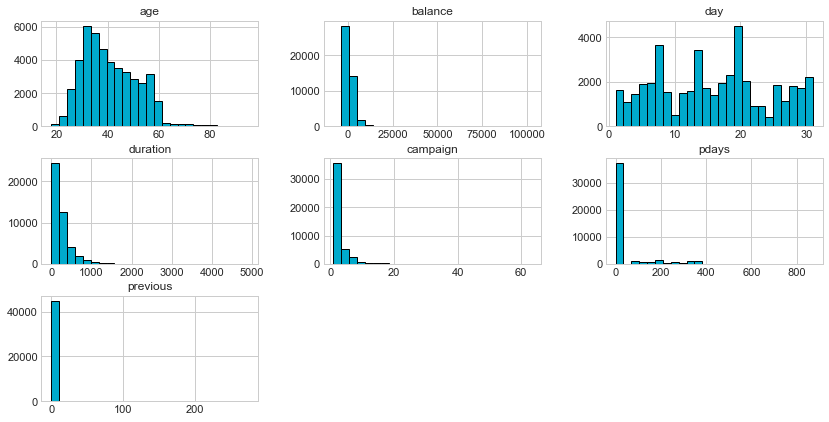

In [27]:
plt.style.use('seaborn-whitegrid')
dataframe.hist(bins = 25, figsize = (14, 7), color = "#00AACC", edgecolor = 'black')
plt.show()

Проанализировав образование клиентов, видно, что значительное большинство от вклада отказываются. Больше всего вклады берут люди со среднем (secondary) образованием, затем люди с высшим/дополнительным (teritary). 

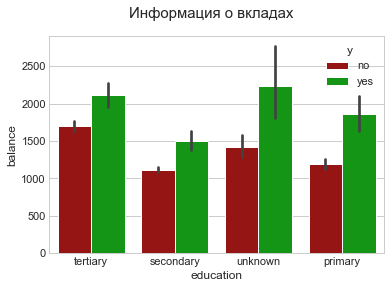

In [28]:
labels = "Отказались от вклада", "Открыли вклад"
plt.suptitle("Информация о вкладах", fontsize = 15)
colors = ["#AA0000", "#00AA00"]
seaborn.barplot(
    x         = "education",
    y         = "balance",
    hue       = "y",
    data      = dataframe,
    palette   = colors,
)
plt.show()

Выразим согласившихся/отказавшихся в процентном соотношении. Классы значительно несбалансированы.

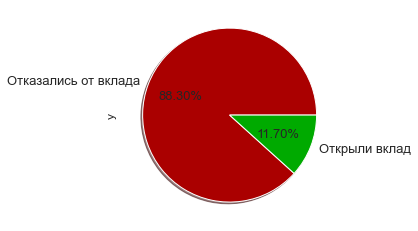

In [29]:
dataframe["y"]       \
    .value_counts()  \
    .plot            \
    .pie(autopct = "%1.2f%%", shadow = True, colors = colors, labels = labels, fontsize = 13)
plt.show()

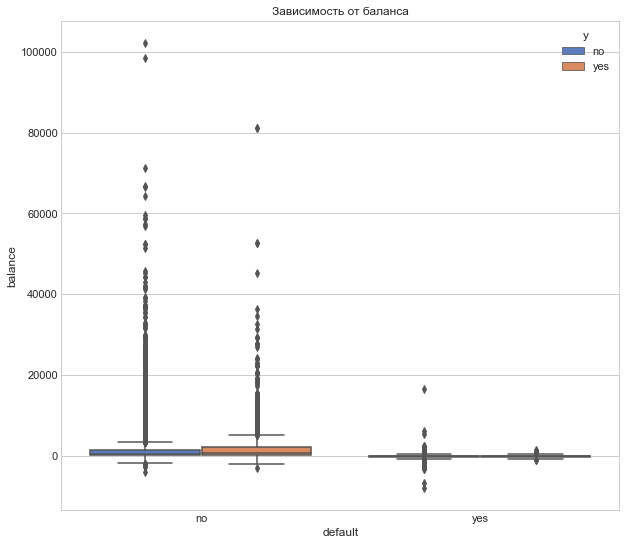

In [30]:
figure, axis = plt.subplots(figsize = (10, 9))
first = seaborn.boxplot(x = "default", y = "balance", hue = "y", data = dataframe, palette = "muted")
first.set_title("Зависимость от баланса")
plt.show()

Примерно видно, что больше всего получают люди из сектора Management, студенты и безработные, логично, обычно безденежные и не хотят брать депозиты. Люди на пенсии более склонны брать или продлевать депозит (тоже логично, т.к. накопления позволяют безбедно перенести пенсию, и накопленное можно будет передать по наследству). Интересно, что у студентов нет долгов, а отрицательные счета наблюдаются в значительной степени у сектора менеджмента и у "синих воротничков". 

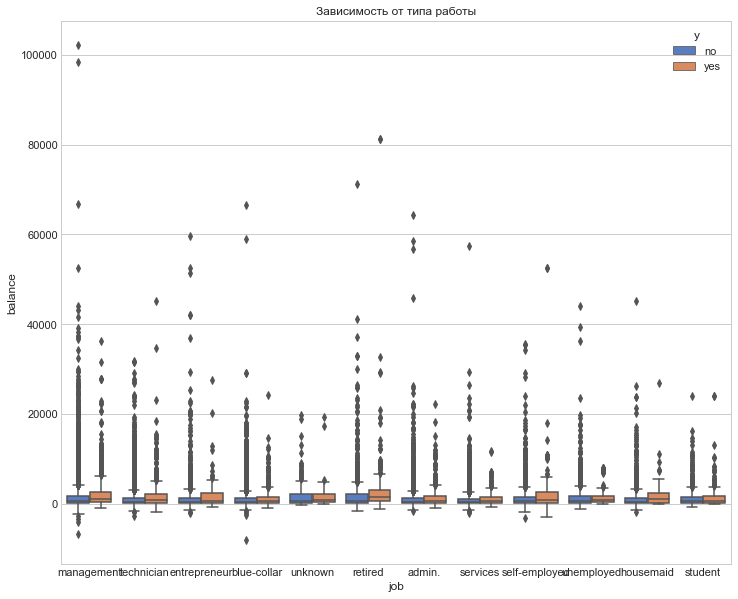

In [31]:
figure, axis = plt.subplots(figsize = (12, 10))
second = seaborn.boxplot(x = "job", y = "balance", hue = "y", data = dataframe, palette = "muted")
second.set_title("Зависимость от типа работы")
plt.show()

Больше всего данных было собрано о менеджерах/начальниках, о "синих воротничках" (физический труд с почасовой оплатой), о техниках. Незначительная часть людей отказались предоставлять информацию о себе.

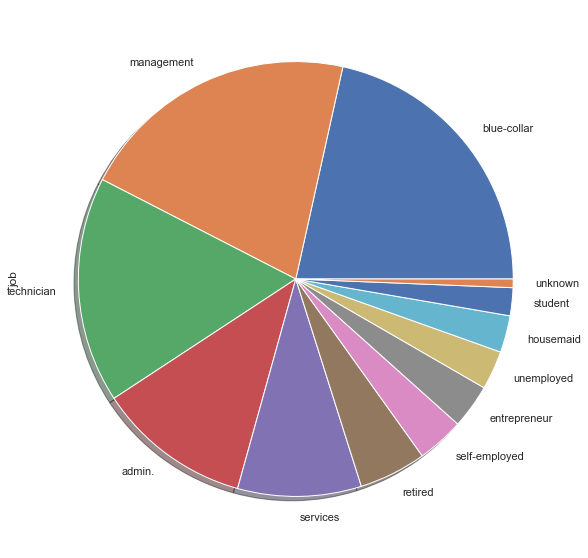

In [32]:
figure, axis = plt.subplots(figsize = (10, 10))
dataframe["job"].value_counts().plot.pie(shadow = True)
plt.show()

По сути, ничего особенного выделить нельзя. Очевидно, что все люди на пенсии (retired) редко младше 50, а в основном -- около 70. Также очевидно, что почти все студенты молодые. Предприниматели более "редко" распределены по возрасту, он может быть как и молодой, так и пожилой. Нет конкретной связи между возрастом и безработицей. Очень мало молодых домохозяек. 

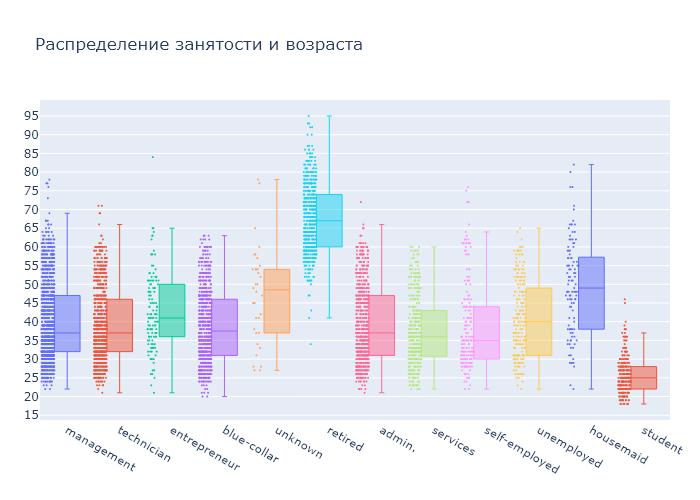

In [33]:
from plotly import tools
import chart_studio.plotly
import plotly.figure_factory
import plotly.graph_objs
from IPython.display import Image

deposited = dataframe.loc[dataframe["y"] == "yes"]
employment = dataframe["job"].unique().tolist()
ages = [deposited["age"].loc[deposited["job"] == name].values for name in employment]

data = [plotly.graph_objs.Box(
        y            = ys,
        name         = xs,
        boxpoints    = 'all',
        jitter       = 0.5,
        whiskerwidth = 0.2,
        marker       = dict(size = 2,),
        line         = dict(width = 1)) for xs, ys in zip(employment, ages)]
layout = plotly.graph_objs.Layout(
    title = "Распределение занятости и возраста",
    yaxis = dict(
        autorange     = True,
        showgrid      = True,
        zeroline      = True,
        dtick         = 5,
        gridcolor     = 'rgb(255, 255, 255)',
        gridwidth     = 1,
        zerolinecolor = 'rgb(255, 255, 255)',
        zerolinewidth = 2,
    ),
    margin = dict(l = 40, r = 30, b = 80, t = 100,),
    showlegend = False
)

figure = plotly.graph_objs.Figure(data = data, layout = layout)
figure.write_image("fig1.png")
# plot.ly refuses to be rendered both on GitHub and JupyterLab. What a shame.
# If you ever encounter this particular line and would like to execute a script on your local machine, uncomment:
# figure.show()
# ... and comment a line below.
Image(filename = 'fig1.png') 

Теперь попробуем проанализировать семейное положение. Видно, что большая часть жената/замужем, и меньшая часть никогда не была жената/замужем. Есть определенный процент разведенных людей. Пока что, выводы поверхностные, попробуем немного углубиться. 

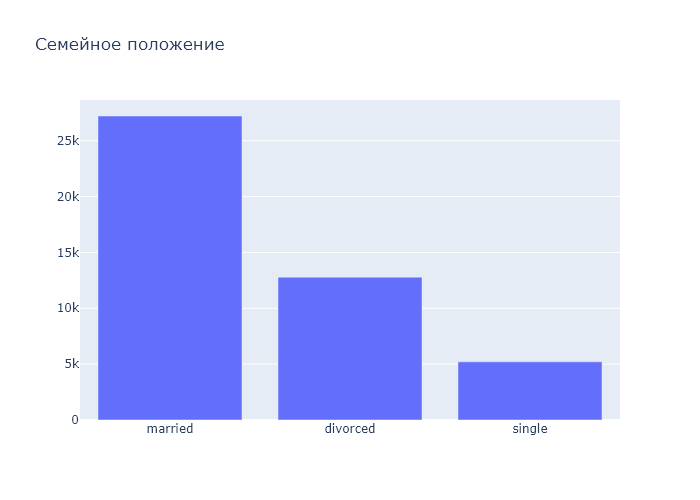

In [34]:
values = dataframe["marital"].value_counts().tolist()
labels = ["married", "divorced", "single"]
data = [plotly.graph_objs.Bar(x = labels, y = values)]
layout = plotly.graph_objs.Layout(title = "Семейное положение")
figure = plotly.graph_objs.Figure(data = data, layout = layout)
figure.write_image("fig2.png")
Image(filename = 'fig2.png') 

Интересно, что у разведенных на балансе денег значительно меньше. Также уровень доходов напрямую коррелирует с качеством образования. Что же, возьмём на заметку :)

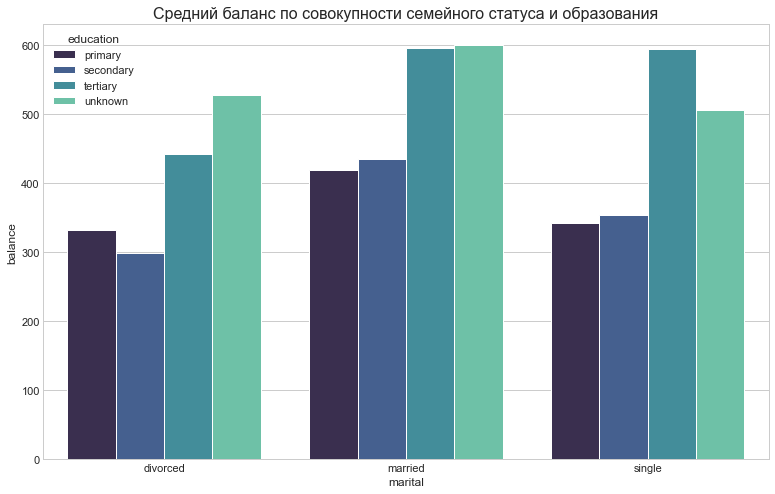

In [35]:
groups = dataframe.groupby(["marital", 'education'], as_index = False)["balance"].median()
figure = plt.figure(figsize = (13, 8))
seaborn.barplot(
    x       = "marital",
    y       = "balance",
    hue     = "education",
    data    = groups,
    palette = "mako"
)
plt.title("Средний баланс по совокупности семейного статуса и образования", fontsize = 16)
plt.show()

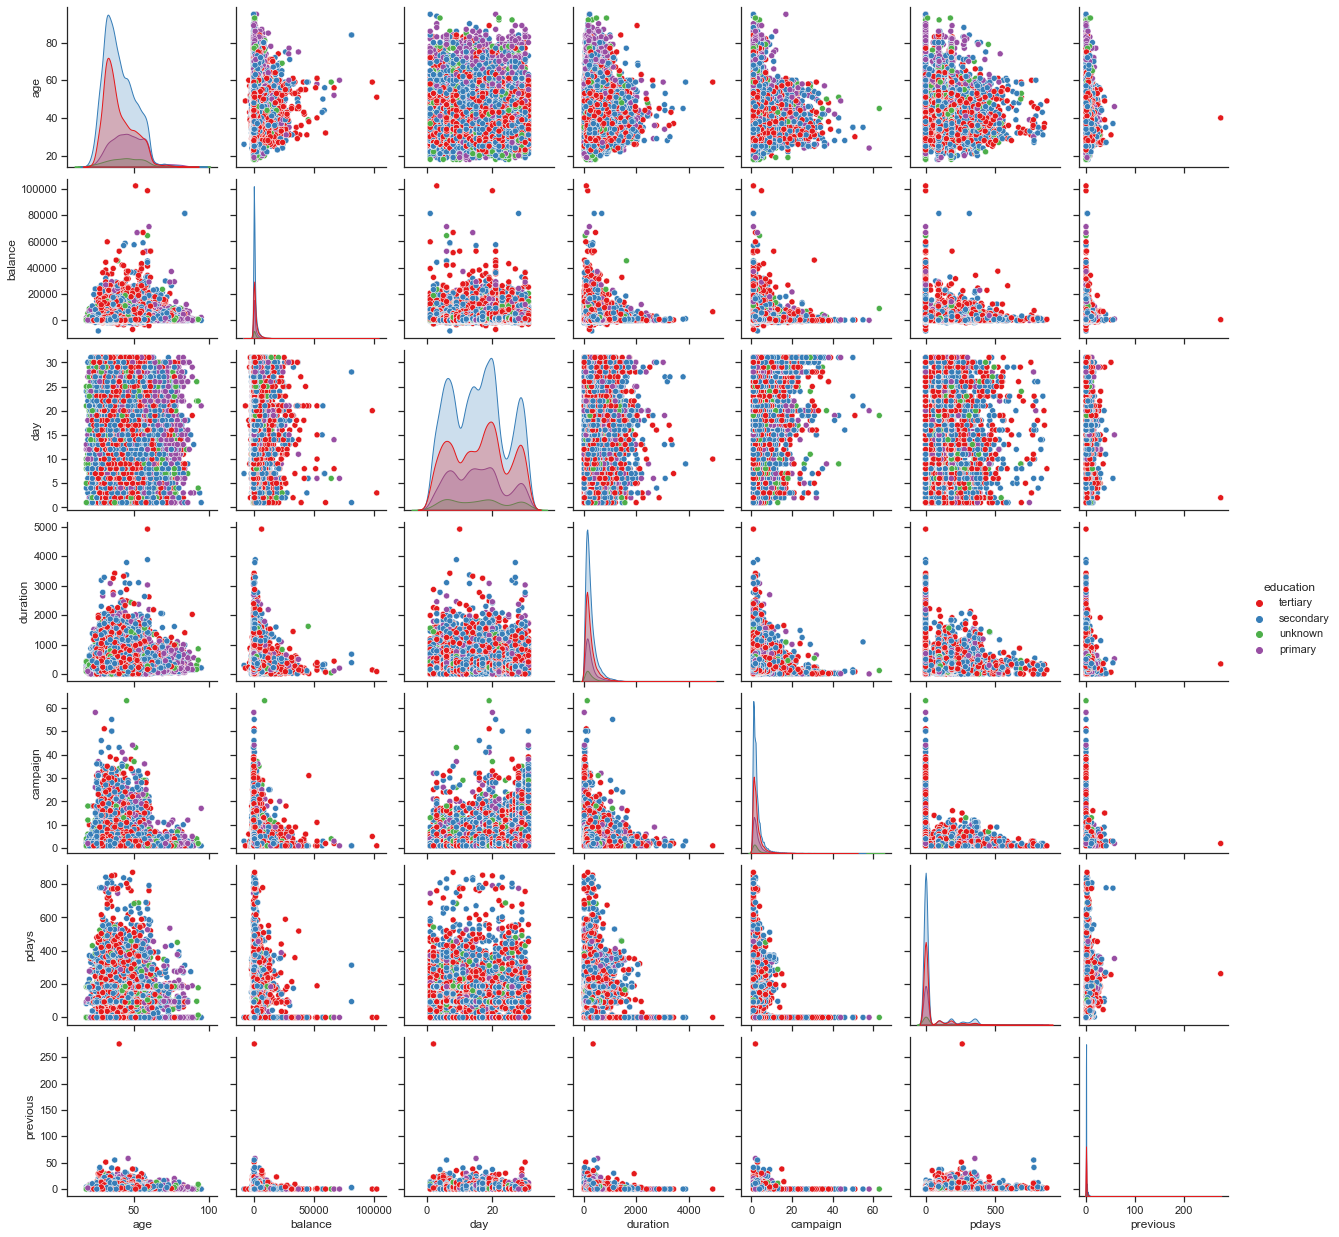

In [36]:
seaborn.set(style = "ticks")
seaborn.pairplot(dataframe, hue = "education", palette = "Set1")
plt.show()

По pairwise-plot особо сказать ничего нельзя. Судя по данным, банк сначала опрашивает людей с высшим образованием, а затем со средним (см. распр. day), выделяются несколько десятков богатых людей с высшим образованием.
Попробуем же теперь рассмотреть характеристику **duration**. Возможно, чем дольше мы будем уговаривать человека на открытие счёта, тем больше вероятность того, что он согласится с нашим подходом. Или наоборот?

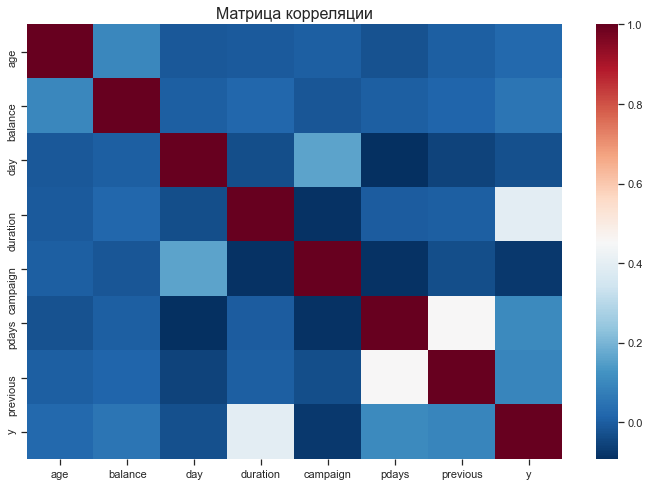

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
figure = plt.figure(figsize = (12, 8))
dataframe["y"] = sklearn.preprocessing.LabelEncoder().fit_transform(dataframe["y"])
# Since all the categorical types are represented by "object" type, we can surely drop it.
numeric = dataframe.select_dtypes(exclude = "object")
correlation_matrix = numeric.corr()
seaborn.heatmap(correlation_matrix, cbar = True, cmap = "RdBu_r")
plt.title("Матрица корреляции", fontsize = 16)
plt.show()

Отказывается, что ни возраст, ни баланс, ни другие характеристики не влияют на вероятность открытия счёта. Зато продолжительность звонка в какой-то степени коррелирует.

In [38]:
dataframe['y']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int32

In [39]:
def bool_dummy(row, column):
    return 1 if row[column] == "yes" else 0

def get_values(row, column, threshold, dataframe):
    if row[column] <= threshold: return row[column]
    else: return dataframe[dataframe[column] <= threshold][column].mean()
    
# TO-DO: re-write, this is horrible. 
def clean(dataframe):
    cleaned     = dataframe.copy()
    to_drop     = ["default", "housing", "loan"]
    categorical = ["job", "marital", "education", "contact", "month", "poutcome"]
    for column in to_drop: 
        cleaned[column + '_bool'] = dataframe.apply(lambda row: bool_dummy(row, column), axis = 1)
    cleaned     = cleaned.drop(columns = to_drop)
    for column in categorical:
        cleaned = pd.concat(
            [cleaned.drop(column, axis = 1), pd.get_dummies(
                cleaned[column], 
                prefix     = column, 
                prefix_sep = '_', 
                drop_first = True,
                dummy_na   = False
            )],
            axis = 1
        )
    cleaned = cleaned.drop(columns = ['pdays'])
    cleaned['cleaned_campaign'] = dataframe.apply(lambda row: get_values(row, 'campaign', 34, cleaned), axis = 1)
    cleaned['cleaned_previous'] = dataframe.apply(lambda row: get_values(row, 'previous', 34, cleaned), axis = 1)
    cleaned = cleaned.drop(columns = ['campaign', 'previous'])
    return cleaned

In [40]:
cleaned = clean(dataframe)
cleaned.head()

,age,balance,day,duration,y,default_bool,housing_bool,loan_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,cleaned_campaign,cleaned_previous
0,58,2143,5,261,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
1,44,29,5,151,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
2,33,2,5,76,0,0,1,1,0,1,...,0,1,0,0,0,0,0,1,1.0,0.0
3,47,1506,5,92,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,1.0,0.0
4,33,1,5,198,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0


In [41]:
import sklearn.model_selection
import sklearn.pipeline
X = cleaned.drop(columns = 'y')
y = cleaned['y']

In [42]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 42)

Попробуем прогнать KN-classifier и взглянуть на точность. Дополнительный анализ проведен не был (можно было построить кривые ROC-AUC), сравним точность с XGBoost.

In [43]:
import sklearn.neighbors
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train.squeeze().values)
y_train_preds_knn, y_test_preds_knn = knn.predict(X_train), knn.predict(X_test)
print('acc_train_knn: %.3f: acc_test_knn: %.3f' % (
    sklearn.metrics.accuracy_score(y_train, y_train_preds_knn), 
    sklearn.metrics.accuracy_score(y_test, y_test_preds_knn)
))

acc_train_knn: 0.904: acc_test_knn: 0.876


In [44]:
import xgboost
xgb = xgboost.XGBClassifier \
    (n_estimators     = 75,  # Completely random.
     learning_rate    = 0.1, # Random as well.
     subsample        = 0.7 #
    )

xgb.fit(X_train, y_train.squeeze().values)
y_train_preds, y_test_preds = xgb.predict(X_train), xgb.predict(X_test)

print('acc_train: %.3f: acc_test: %.3f' % (
        sklearn.metrics.accuracy_score(y_train, y_train_preds),
        sklearn.metrics.accuracy_score(y_test, y_test_preds)))

acc_train: 0.926: acc_test: 0.907


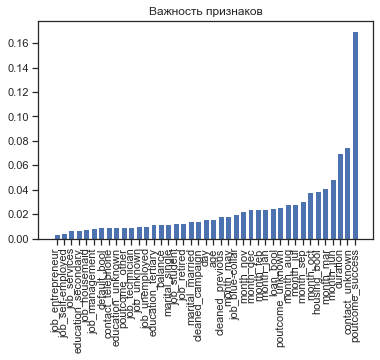

In [45]:
headers = ["Feature", "Score"]
feature_df = pd.DataFrame(sorted(zip(X_train.columns, xgb.feature_importances_), key = lambda x: x[1]), columns = headers)
x_pos = np.arange(0, len(feature_df))
plt.bar(x_pos, feature_df["Score"])
plt.xticks(x_pos, feature_df["Feature"])
plt.xticks(rotation = 90)
plt.title('Важность признаков')
plt.show()

**Выводы**

1. Судя по имеющимся распределениям, приоритетным направлением должен быть сектор менеджмента, а также люди, занимающиеся физическим трудом.

2. Следует ориентироваться на людей с образованием -- больше шанс на открытие депозита (т.к. их больше в количественном соотношении, что очевидно).

3. По матрице корреляции можно сказать две вещи. Чем дольше мы звоним (объясняем, какие достоинства у наших депозитов), тем больше вероятность, что клиент согласится. С точки зрения здравого смысла это не всегда верно -- надоедливость может клиента отпугнуть. Также, нужно продолжать работать с теми, с кем уже состоялся длительный разговор.
   
4. Также необходимо ориентироваться необходимо на людей постарше -- как видно по pairwise-plot, где-то в середине balance максимальный.

5. Самыми значительными признаками, которые позволили бы определить вероятность открытия счёта -- длительность предыдущего контакта (причём неизвестно, какого рода, видимо, предполагается очная встреча в отделении банка, например), март и июнь (на этот период приходится наибольшее количество согласий), а также длительность последнего контакта.